## Grad-CAM Exploration
**Data**: MixedWM38 single defect only

**Data preprocessing**: Resize to 224x224, binarize, and apply n=2 morphological thinning

**Model**: Tandem inference implementation of the detection and classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

In [1]:
!pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the data

In [5]:
# specify variables

# specify data to load
path = 'processed_data/customer'
filename = 'MixedWM38-single'
labeled = True

# where to save results
result_path = 'results'
result_filename = 'yutandem-224thin2-norotflip-mixedwm38-single'

# which models to run
detect_model = 'yudetect-224-thin2'
classify_model = 'yuclassify-224thin2-norotflip'

In [6]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = f'{path}/{filename}.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")

Wall time: 0.41 seconds
Dataset length: 8015


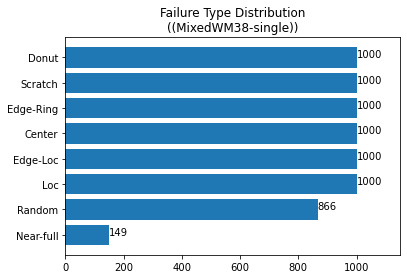

In [7]:
# IF LABELED
# show failure type distribution
if labeled:
    data_defects = data[data.detectLabels == 1]
    helper.defect_distribution(data_defects, note=f'({filename})')

### Data preprocessing

In [8]:
# resize to 224x224 --> binarize --> apply n=2 morphological thinning
start = time.time()

def resize(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    return new_y
    
data['waferMap224'] = data.waferMap.apply(lambda x: resize(x))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.waferMap224[0].shape}')
print(f'Map unique values:{np.unique(data.waferMap224[0])}')

Wall time: 17.45 seconds
Sanity checks:
Map shape: (224, 224)
Map unique values:[0 1 2]


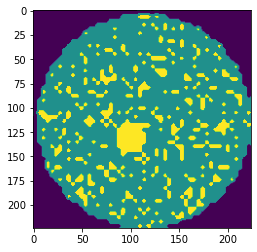

In [9]:
plt.imshow(data.waferMap224[0])

In [10]:
# resize to 224x224 --> binarize --> apply n=2 morphological thinning
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    thin_img = thin(thresh_img, 2)
    return thin_img
    
data['thinMap2'] = data.waferMap.apply(lambda x: preprocess(x))
data['thinMap2'] = data.thinMap2.apply(lambda x: x.astype(np.uint8))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.thinMap2[0].shape}')
print(f'Map unique values:{np.unique(data.thinMap2[0])}')

Wall time: 50.89 seconds
Sanity checks:
Map shape: (224, 224)
Map unique values:[0 1]


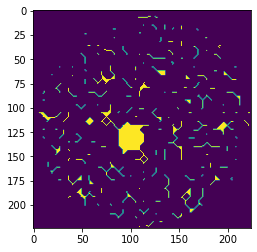

In [11]:
plt.imshow(data.thinMap2[0])

### Detect Model

In [12]:
# load saved detect model from S3
start = time.time()

detect = s3_get_keras_model(detect_model)
detect.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

### Classify Model

In [13]:
# load saved classify model from S3
start = time.time()

classify = s3_get_keras_model(classify_model)
classify.summary()

print("Wall time: {:.2f} seconds".format(time.time() - start))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       7

### Load Model Results
Saved predictions include 4 lists:
- IDs of defective wafers identified by detect model
- Output of detect model (softmax probabilities)
- Output of classify model (softmax probabilities)
- Labels predicted by tandem model

In [14]:
# load predictions
predictions_path = '../../pipeline/results/yutandem-224thin2-mixedwm38-single.pkl'
with open(predictions_path, "rb") as fh:
    predictions = pickle.load(fh)

# unpack predictions
defect_ids = predictions[0]
detect_probs = predictions[1]
classify_probs = predictions[2]
labels = predictions[3]

# probabilities for the highest class for each model
detect_max_prob = [max(x) for x in detect_probs]
classify_max_prob = [max(x) for x in classify_probs]

# second highest class for defective sample
classify_label2 = [x.argsort()[-2] for x in classify_probs]

# second highest class probability
classify_max_prob2 = [x[i] for x, i in zip(classify_probs, classify_label2)]

# add columns to dataframe
data['pred_labels'] = labels

# add column of probabilities predicted class 
def add_max_prob(row):
    i = row.name
    if row['pred_labels'] == 8:
        return detect_max_prob[i] * 100
    else:
        j = defect_ids.index(data.ID[i])
        return (detect_max_prob[i] * classify_max_prob[j]) * 100

data['pred_prob'] = data.apply(lambda row: add_max_prob(row), axis=1)

print(data.shape)
data.head()

(8015, 11)


,ID,waferMap,labels,label_total,failureType,detectLabels,classifyLabels,waferMap224,thinMap2,pred_labels,pred_prob
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,59.258890
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,93.669462
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,83.966368
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,98.426312
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,97.900438


In [16]:
# import random

# defects = [i for i in range(len(data)) if (data.failureType.loc[i] == 'none' and data.pred_labels.loc[i] == 2 and data.pred_prob.loc[i] > 90)]
# print(len(defects))
# random_n = random.sample(defects, 5)
# random_n

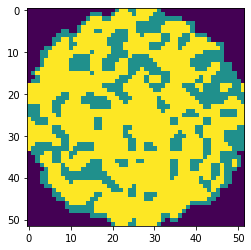

In [17]:
plt.imshow(data.waferMap[6898])

### Grad-CAM Exploration

In [18]:
# good and bad examples
good_indices = [4315, 2101, 485, 3210, 7773, 5766, 6873, 1264, 6673]
bad_indices = [4620, 2208, 350, 7356, 5535, 6898, 1023]

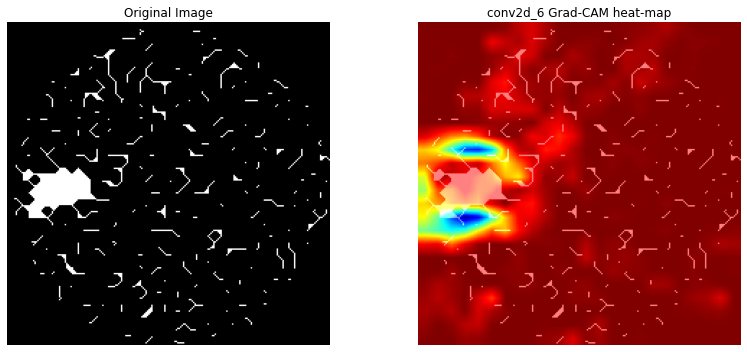

In [24]:
from gradcam import *

#i = data[data.ID == 2887].index[0]
i = 4315
img = data.thinMap2[i]

## Grad-CAM heatmap for the last convolutional layer in the model
layer_name = 'conv2d_6'
grad_cam=GradCam(classify, img, layer_name)

# generate superimposed image
img_bgr = generate_img_bgr(img, binary=True)
grad_cam_superimposed = superimpose(img_bgr, grad_cam, emphasize=False, img_wt=0.5, heatmap_wt=1)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img_bgr)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

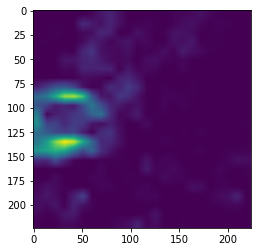

In [25]:
plt.imshow(grad_cam)

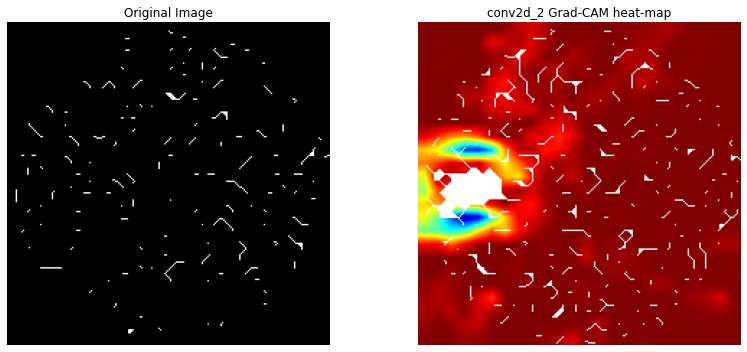

In [26]:
from gradcam import *

#i = data[data.ID == 2887].index[0]
i = 6673
img = data.thinMap2[i]

## Grad-CAM heatmap for the last convolutional layer in the model
layer_name = 'conv2d_2'
grad_cam2=GradCam(detect, img, layer_name)

# generate superimposed image
img_bgr2 = generate_img_bgr(img, binary=True)
grad_cam_superimposed2 = superimpose(img_bgr, grad_cam, emphasize=False, img_wt=1, heatmap_wt=1)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img_bgr2)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title(f'{layer_name} Grad-CAM heat-map')
plt.tight_layout()

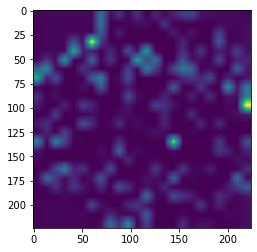

In [27]:
plt.imshow(grad_cam2)

In [28]:
# good and bad examples
good_indices = [4315, 2101, 485, 3210, 7773, 5766, 6873, 1264, 6673]
bad_indices = [4620, 2208, 350, 0, 7356, 5535, 6898, 1023, 0]

In [29]:
# make list of images
good_imgs = [data.thinMap2[i] for i in good_indices]
bad_imgs = [data.thinMap2[i] if i > 0 else np.zeros((224,224)) for i in bad_indices]

In [30]:
# make a list of classify Grad-CAM images
layer_name = 'conv2d_6'
layer_name2 = 'conv2d_2'

good_gcs = []
for i in range(9):
    if i == 8:
        grad_cam=GradCam(detect, good_imgs[i], layer_name2)
        good_gcs.append(grad_cam)
    else:
        grad_cam=GradCam(classify, good_imgs[i], layer_name)
        good_gcs.append(grad_cam)
print(len(good_gcs))

bad_gcs = []
for i in range(9):
    if i == 3 or i == 8:
        bad_gcs.append(np.zeros((224,224)))
    elif i == 4:
        grad_cam=GradCam(detect, bad_imgs[i], layer_name2)
        bad_gcs.append(grad_cam)
    else:
        grad_cam=GradCam(classify, bad_imgs[i], layer_name)
        bad_gcs.append(grad_cam)
print(len(bad_gcs))

9
9


In [31]:
# label lists
true_labels = ['Loc', 'Edge-Loc', 'Center', 'Edge-Ring', 'Scratch', 'Random', 'Near-Full', 'Donut', 'None']
bad_labels = ['Edge-Loc', 'Edge-Ring', 'Loc', '---', 'None', 'Edge-Loc', 'Random', 'Center', '---']

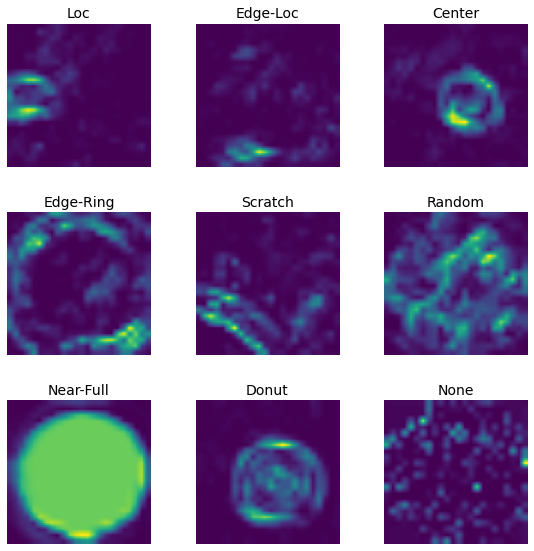

In [32]:
# plot good grad-cams
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = good_gcs[x]
    ftype = true_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='viridis')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}', fontsize=14)

plt.show()

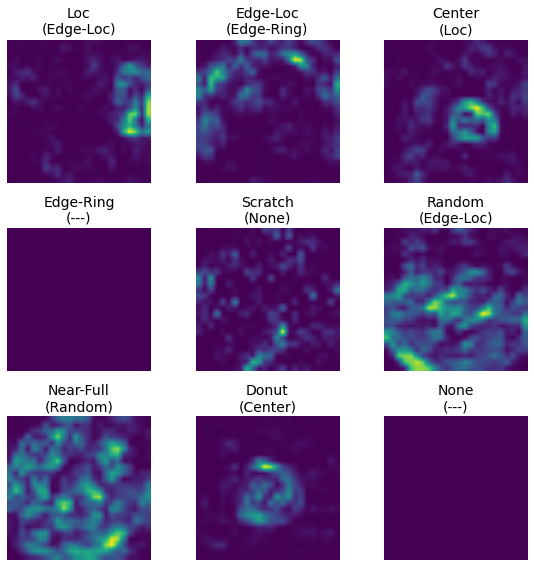

In [33]:
# plot bad grad-cams
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = bad_gcs[x]
    ftype = true_labels[x]
    mistake = bad_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='viridis')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}\n({mistake})', fontsize=14)

plt.show()